Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.



# Importing all the important libraries

In [25]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import Augmentor
import keras_tuner as kt
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [26]:
# train directory
train_dir = pathlib.Path('Train').rglob('*.jpg')
# test directiry
test_dir = pathlib.Path('Test').rglob('*.jpg')

In [27]:
# training images
train_files = list(train_dir)
train_files[:5]

[WindowsPath('Train/actinic keratosis/ISIC_0025780.jpg'),
 WindowsPath('Train/actinic keratosis/ISIC_0025803.jpg'),
 WindowsPath('Train/actinic keratosis/ISIC_0025825.jpg'),
 WindowsPath('Train/actinic keratosis/ISIC_0025953.jpg'),
 WindowsPath('Train/actinic keratosis/ISIC_0025957.jpg')]

In [28]:
# testing image
test_files = list(test_dir)
test_files[:5]

[WindowsPath('Test/actinic keratosis/ISIC_0010512.jpg'),
 WindowsPath('Test/actinic keratosis/ISIC_0010889.jpg'),
 WindowsPath('Test/actinic keratosis/ISIC_0024468.jpg'),
 WindowsPath('Test/actinic keratosis/ISIC_0024470.jpg'),
 WindowsPath('Test/actinic keratosis/ISIC_0024511.jpg')]

In [29]:
def createDataframe(files):
    paths = []
    labels = []
    for path in files:
        label = path.parts[1] 
        paths.append(path)
        labels.append(label)
    df = pd.DataFrame({
        'path': paths,
        'label': labels
    })
    return df

In [30]:
train_df = createDataframe(train_files)
train_df.head()

,path,label
0,Train\actinic keratosis\ISIC_0025780.jpg,actinic keratosis
1,Train\actinic keratosis\ISIC_0025803.jpg,actinic keratosis
2,Train\actinic keratosis\ISIC_0025825.jpg,actinic keratosis
3,Train\actinic keratosis\ISIC_0025953.jpg,actinic keratosis
4,Train\actinic keratosis\ISIC_0025957.jpg,actinic keratosis


In [31]:
test_df = createDataframe(test_files)
test_df.head()

,path,label
0,Test\actinic keratosis\ISIC_0010512.jpg,actinic keratosis
1,Test\actinic keratosis\ISIC_0010889.jpg,actinic keratosis
2,Test\actinic keratosis\ISIC_0024468.jpg,actinic keratosis
3,Test\actinic keratosis\ISIC_0024470.jpg,actinic keratosis
4,Test\actinic keratosis\ISIC_0024511.jpg,actinic keratosis


In [32]:
train_df.value_counts('label')

label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
dtype: int64

In [33]:
class_names = train_df.label.unique().tolist()
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

## Visualise label count 

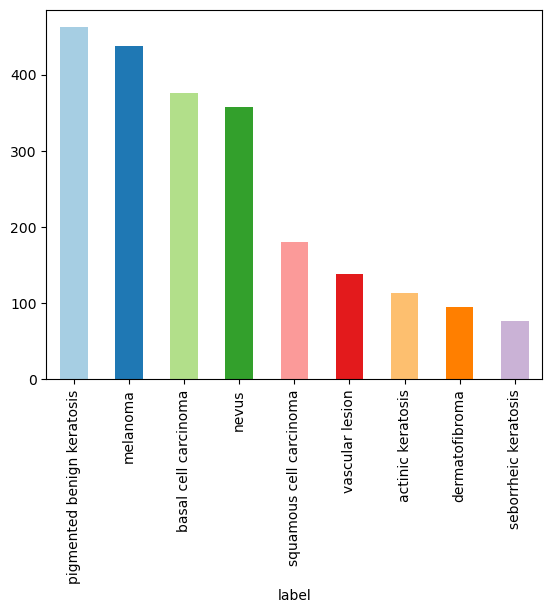

In [34]:
train_df.value_counts('label').plot(kind='bar',color= plt.cm.Paired.colors)
plt.show()

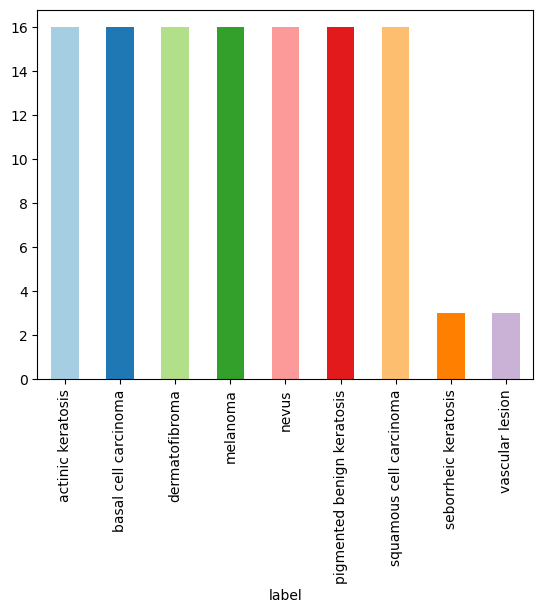

In [35]:
test_df.value_counts('label').plot(kind='bar',color= plt.cm.Paired.colors)
plt.show()

## View some random sample

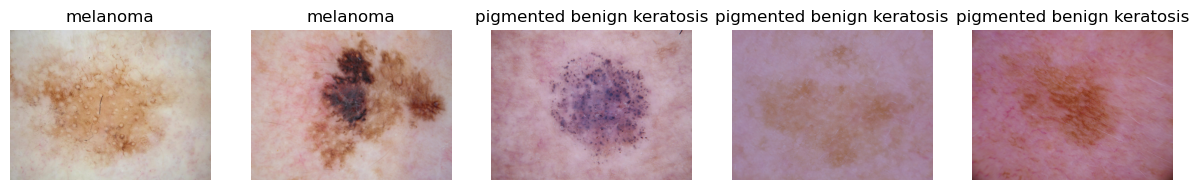

In [36]:
# Select a random sample of images
sample = train_df.sample(n=5)

# Plot the images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for ax, (_, row) in zip(axes, sample.iterrows()):
    img = mpimg.imread(row['path'])
    ax.imshow(img)
    ax.set_title(row['label'])
    ax.axis('off')  # Turn off axis

plt.show()

### Write your findings here:
- **Which class has the least number of samples?**
- **Which classes dominate the data in terms proportionate number of samples?**

### Observation:
- A clear class imbalance is evident within the training data.
- The class "**seborrheic keratosis**" comprises the smallest proportion of samples

## Rectify the class imbalance

In [37]:
class_counts = train_df.value_counts('label').to_dict()
class_counts

{'pigmented benign keratosis': 462,
 'melanoma': 438,
 'basal cell carcinoma': 376,
 'nevus': 357,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139,
 'actinic keratosis': 114,
 'dermatofibroma': 95,
 'seborrheic keratosis': 77}

In [38]:
max_count = max(class_counts.values())
max_count

462

In [39]:
def augment_class_images(class_name, current_count,class_count=class_counts):
    train_dir = pathlib.Path('Train')
    max_count = max(class_counts.values())
    class_dir = train_dir / class_name
    pipeline = Augmentor.Pipeline(str(class_dir))
    pipeline.flip_left_right(probability=0.7)
    pipeline.zoom_random(probability=0.5, percentage_area=0.8)
    pipeline.rotate(probability=0.6, max_left_rotation=10, max_right_rotation=10)

    # Calculate how many images to generate for this class
    num_to_generate = max_count - current_count
    if num_to_generate > 0:
        print(f"Augmenting class: {class_name} (Current count: {current_count}, Generating: {num_to_generate})")
        pipeline.sample(num_to_generate)

In [40]:
for class_name, count in class_counts.items():
    if count < max_count:
        augment_class_images(class_name, count)

Initialised with 438 image(s) found.
Output directory set to Train\melanoma\output.Augmenting class: melanoma (Current count: 438, Generating: 24)


Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2752EC37210>: 100%|█| 24/24 [00:01<00:00, 22.76 Samples/s


Initialised with 376 image(s) found.
Output directory set to Train\basal cell carcinoma\output.Augmenting class: basal cell carcinoma (Current count: 376, Generating: 86)


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2752C6135D0>: 100%|█| 86/86 [00:00<00:00, 167.87 Samples/s


Initialised with 357 image(s) found.
Output directory set to Train\nevus\output.Augmenting class: nevus (Current count: 357, Generating: 105)


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2752E6FFED0>: 100%|█| 105/105 [00:02<00:00, 44.83 Samples/


Initialised with 181 image(s) found.
Output directory set to Train\squamous cell carcinoma\output.Augmenting class: squamous cell carcinoma (Current count: 181, Generating: 281)


Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2752FA70B90>: 100%|█| 281/281 [00:01<00:


Initialised with 139 image(s) found.
Output directory set to Train\vascular lesion\output.Augmenting class: vascular lesion (Current count: 139, Generating: 323)


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2752EB58850>: 100%|█| 323/323 [00:01<00:00, 169.04 Samples


Initialised with 114 image(s) found.
Output directory set to Train\actinic keratosis\output.Augmenting class: actinic keratosis (Current count: 114, Generating: 348)


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2752E710D90>: 100%|█| 348/348 [00:02<00:00, 158.54 Samples


Initialised with 95 image(s) found.
Output directory set to Train\dermatofibroma\output.Augmenting class: dermatofibroma (Current count: 95, Generating: 367)


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2752E6EDFD0>: 100%|█| 367/367 [00:02<00:00, 172.30 Samples


Initialised with 77 image(s) found.
Output directory set to Train\seborrheic keratosis\output.Augmenting class: seborrheic keratosis (Current count: 77, Generating: 385)


Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2752EC08150>: 100%|█| 385/385 [00:04<00:00, 78.22 Samples


In [41]:
train_df.value_counts('label')

label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
dtype: int64

# Images after augmentation and class balance

In [42]:
train_augmented_files = list(pathlib.Path('Train').rglob('output/*.jpg'))
len(train_augmented_files)

1919

In [43]:
train_augmented_df = createDataframe(train_augmented_files)
train_augmented_df.head()

,path,label
0,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
1,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
2,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
3,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
4,Train\actinic keratosis\output\actinic keratos...,actinic keratosis


In [44]:
train_df_balanced = pd.concat([train_df,train_augmented_df],axis=0)
train_df_balanced.head()

,path,label
0,Train\actinic keratosis\ISIC_0025780.jpg,actinic keratosis
1,Train\actinic keratosis\ISIC_0025803.jpg,actinic keratosis
2,Train\actinic keratosis\ISIC_0025825.jpg,actinic keratosis
3,Train\actinic keratosis\ISIC_0025953.jpg,actinic keratosis
4,Train\actinic keratosis\ISIC_0025957.jpg,actinic keratosis


In [45]:
train_df_balanced.value_counts('label')

label
actinic keratosis             462
basal cell carcinoma          462
dermatofibroma                462
melanoma                      462
nevus                         462
pigmented benign keratosis    462
seborrheic keratosis          462
squamous cell carcinoma       462
vascular lesion               462
dtype: int64

In [46]:
train_df_balanced.shape

(4158, 2)

**Now we have successfully handled class imbalance**

## Training CNN Model

In [47]:
batch_size = 32
img_height = 256
img_width = 256

### Training Dataset

In [48]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  pathlib.Path('Train'),
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4158 files belonging to 9 classes.
Using 3327 files for training.


In [49]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  pathlib.Path('Train'),
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4158 files belonging to 9 classes.
Using 831 files for validation.


### Validation data set

In [50]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  pathlib.Path('Test'),
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 95 files for training.


In [51]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [52]:
def build_model(hp):
    """
    Function to build a Keras model with hyperparameters for tuning.
    """
    # Hyperparameters
    conv_layers = hp.Int('conv_layers', min_value=3, max_value=6)  # Reduced max layers
    padding = hp.Choice('padding', values=['same', 'valid'])
    pool_size = hp.Choice('pool_size', values=[2, 3])
    dense_layers = hp.Int('dense_layers', min_value=1, max_value=5)  # Reduced max layers
    filters = hp.Int('filters', min_value=32, max_value=256, step=32)  # Reduced filter sizes
    kernel_size = hp.Choice('kernel_size', values=[3, 5])
    dense_units = hp.Int('dense_units', min_value=32, max_value=256, step=32)  # Reduced units
    activation = hp.Choice('activation', values=['relu', 'tanh'])
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)

    # Initialize the model
    model = keras.Sequential([
        layers.Input(shape=(img_height, img_width, 3)),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ])

    # Add convolutional layers
    for _ in range(conv_layers):
        model.add(layers.Conv2D(filters, kernel_size, activation=activation, padding=padding))
        model.add(layers.MaxPooling2D(pool_size=pool_size))
        model.add(layers.Dropout(dropout_rate))

    # Flatten before dense layers
    model.add(layers.Flatten())

    # Add dense layers
    for _ in range(dense_layers):
        model.add(layers.Dense(dense_units, activation=activation))
        model.add(layers.Dropout(dropout_rate))

    # Output layer
    model.add(layers.Dense(len(class_counts), activation='softmax'))

    # Optimizer selection
    optimizer = keras.optimizers.Adam(learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [62]:
# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

In [63]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='my_dir',
    project_name='cancer detection',
    overwrite=True,
    seed=42
)

In [64]:
tuner.search(train_ds, epochs=10, validation_data=val_ds,callbacks=[checkpoint,early_stopping])


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
6                 |6                 |conv_layers
same              |same              |padding
2                 |2                 |pool_size
2                 |2                 |dense_layers
240               |240               |filters
3                 |3                 |kernel_size
144               |144               |dense_units
relu              |relu              |activation
adam              |adam              |optimizer
0.00030693        |0.00030693        |learning_rate
0.5               |0.5               |dropout_rate

Epoch 1/10
  3/104 ━━━━━━━━━━━━━━━━━━━━ 2:12:03 78s/step - accuracy: 0.0955 - loss: 516.4528

KeyboardInterrupt: 

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
history = best_model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds 
)


In [ ]:
test_loss, test_accuracy = best_model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")